# Steroids or Pentoxifylline for severe Alcoholic Hepatitis (STOPAH) trial


## Computation of Sobol indices and Shapley effects/values 


#### Implementation of Shapley values, Sobol indices and Shapley effects to prognostic scoring 


### Lille Score 

\begin{equation}
\begin{array}{r}
\mathrm{R}=3.19-(0.101 \times \text { age }(\text { years }))+(0.147 \times \text { albumin }(\mathrm{g} / \mathrm{L}))+(0.0165 \times \Delta \text { bilirubin })- \\
(0.206 \times \text { renal insufficiency }(0 \text { or } 1))-(0.0065 \times \text { day } 0 \text { bilirubin }(\mu \mathrm{mol} / \mathrm{L}))- \\
(0.0096 \times \text { prothrombin time }(\text { seconds }))
\end{array}
\end{equation}

When is a patient considered for a liver transplant:

1. Lille Score > 0.45

2. MELT Score 

3. Chronic Liver Failure Consortium acute-on-chronic liver failure (CLIF-C ACLF) score of ≥ 70

As these scores are linear combinations of the values, the Shapley values are simply each term. 

Our aim is to extend the named scores by generalized versions via GAMS.

In [17]:
import os
import pandas as pd
import numpy as np

#Missing value analysis 
import missingno as msno

#Models 
from sklearn.ensemble import GradientBoostingClassifier
from pygam import * 

#Analytics 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 


import matplotlib.pyplot as plt
import sage 
import shap

import xgboost as xgb

#!/usr/local/Cluster-Apps/python/3.11.0-icl/bin/python3.11 -m pip install ISLP

from ISLP.pygam import (plot, approx_lam, degrees_of_freedom)



In [19]:
df = pd.read_csv('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/stopah/data/stopah.csv')

Lille_var = ['Age.at.randomisation..calc.','Albumin...Merged','Creatinine..mg.dL....Merged',
             'Bilirubin.Merged','Prothrombin.Time..patient....Merged','Bilirubin.day.7','D28_DTH','Prednisolone']

df = df[Lille_var]

In [11]:
#Phillip Code 

df['Renal Insufficency'] = (df['Creatinine..mg.dL....Merged'].loc[:] > 1.3).astype('float')

df = df.drop(['Creatinine..mg.dL....Merged'],axis=1)

In [15]:
df = df.dropna()

df0 = df[df['Prednisolone']==0].drop(['Prednisolone'],axis=1)

df = df[df['Prednisolone']==1].drop(['Prednisolone'],axis=1)

X, y = df.drop('D28_DTH', axis=1), df[['D28_DTH']]

X0, y0 = df0.drop('D28_DTH', axis=1), df0[['D28_DTH']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.2)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, random_state=1,test_size=0.2)

\begin{equation}
\begin{array}{r}
\mathrm{R}=3.19-(0.101 \times \text { age }(\text { years }))+(0.147 \times \text { albumin }(\mathrm{g} / \mathrm{L}))+(0.0165 \times \Delta \text { bilirubin })- \\
(0.206 \times \text { renal insufficiency }(0 \text { or } 1))-(0.0065 \times \text { day } 0 \text { bilirubin }(\mu \mathrm{mol} / \mathrm{L}))- \\
(0.0096 \times \text { prothrombin time }(\text { seconds }))
\end{array}
\end{equation}

Online the Lille Score is computed by

\begin{equation}
\pi = \frac{1}{1+e^{Lille}}.
\end{equation}

Is this correct that there is no - sign ? 

In [16]:
X.columns

Index(['Age.at.randomisation..calc.', 'Albumin...Merged', 'Bilirubin.Merged',
       'Prothrombin.Time..patient....Merged', 'Bilirubin.day.7',
       'Renal Insufficency'],
      dtype='object')

In [5]:
Lille = 3.19 - 0.101 * df['Age.at.randomisation..calc.']  + 0.147 * df['Albumin...Merged'] + \
0.0165 * (df['Bilirubin.day.7'] -df['Bilirubin.Merged']) \
-0.206 * df['Renal Insufficency'] \
- 0.0065 * df['Bilirubin.Merged'] \
- 0.0096 * df['Prothrombin.Time..patient....Merged'] 

#Ask whether probability is computed like this
prop = 1/(1+np.exp(Lille))

<Axes: >

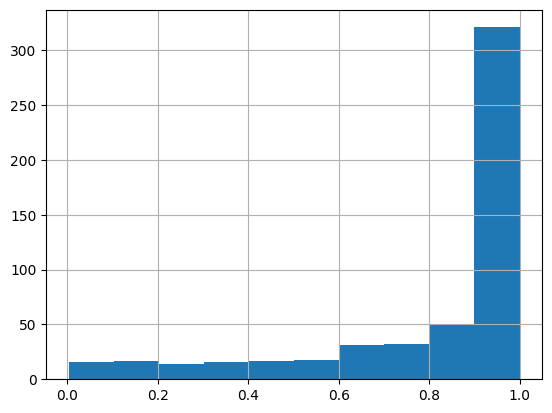

In [6]:
prop.hist()

In [7]:
fpr, tpr, thresholds = roc_curve(y, prop, pos_label=1)
auc(fpr, tpr)

0.47582025256697746

In [8]:
#Build-in hyperparameters

gam  = LogisticGAM().fit(X_train.values,y_train.values)
gam0 = LogisticGAM().fit(X0_train.values,y0_train.values)

clf = GradientBoostingClassifier(n_estimators=1000, 
                                 learning_rate=0.1,
                                 max_depth=8,
                                 #min_child_weight = 1,
                                 random_state=0).fit(X_train, y_train)

#Untreated

clf0= GradientBoostingClassifier(n_estimators=1000, 
                                 learning_rate=0.1,
                                 max_depth=8, 
                                #in_child_weight = 1,
                                 random_state=0).fit(X0_train, y0_train)


Lille0 = 3.19 - 0.101 * df0['Age.at.randomisation..calc.']  + 0.147 * df0['Albumin...Merged'] + \
0.0165 * (df0['Bilirubin.day.7'] -df0['Bilirubin.Merged']) \
-0.206 * df0['Renal Insufficency'] \
- 0.0065 * df0['Bilirubin.Merged'] \
- 0.0096 * df0['Prothrombin.Time..patient....Merged'] 

#Ask whether probability is computed like this
prop0 = 1/(1+np.exp(Lille0))

fpr0, tpr0, thresholds = roc_curve(y0, prop0, pos_label=1)
auc(fpr0, tpr0)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.5069786535303777

In [9]:
print('-----------')
print('GAM')
print('-----------')
print()
print('Untreated')
print()
print('GAM Score:'+str(gam0.score(X0_test, y0_test)))

y0_predict = gam0.predict_proba(X0_test)

auc_score0 = roc_auc_score(y0_test, y0_predict)
print('GAM AUC Score:',(auc_score0)*100)

print()
print('Treated')
print()

print('GAM Score:'+str(gam.score(X_test, y_test)))

y_predict = gam.predict_proba(X_test)

auc_score = roc_auc_score(y_test, y_predict)
print('GAM AUC Score:',(auc_score)*100)

print()
print('-----------')
print('XGB')
print('-----------')

print('Untreated')
print()
print('XGB Score:'+str(clf0.score(X0_test, y0_test)))

y0_predict = clf0.predict_proba(X0_test)

auc_score0 = roc_auc_score(y0_test, y0_predict[:,1])
print('AUC Score:',(auc_score0)*100)

print()
print('Treated')
print()

print('XGB Score:'+str(clf.score(X_test, y_test)))

y_predict = clf.predict_proba(X_test)

auc_score = roc_auc_score(y_test, y_predict[:,1])
print('AUC Score:',(auc_score)*100)

-----------
GAM
-----------

Untreated

GAM Score:0.8317757009345794
GAM AUC Score: 76.4952153110048

Treated

GAM Score:0.8691588785046729
GAM AUC Score: 83.92156862745097

-----------
XGB
-----------
Untreated

XGB Score:0.8504672897196262
AUC Score: 71.05263157894736

Treated

XGB Score:0.8504672897196262
AUC Score: 86.40522875816994


In [10]:
gam.summary()
gam0.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      22.864
Link Function:                        LogitLink Log Likelihood:                                   -133.264
Number of Samples:                          425 AIC:                                               312.256
                                                AICc:                                             315.2218
                                                UBRE:                                               2.7778
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2044
Feature Function                  Lam

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



In [11]:
gam_cv = LogisticGAM().gridsearch(X.to_numpy(), y.to_numpy())
gam_cv0 = LogisticGAM().gridsearch(X0.to_numpy(), y0.to_numpy())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [12]:
print('Untreated')
print()
print('GAM Score:'+str(gam_cv0.score(X0_test, y0_test)))

y0_predict_cv = gam_cv0.predict_proba(X0_test)

auc_score_cv0 = roc_auc_score(y0_test, y0_predict_cv)
print('GAM AUC Score:',(auc_score_cv0)*100)

print()
print('Treated')
print()

print('GAM Score:'+str(gam_cv.score(X_test, y_test)))

y_predict_cv = gam_cv.predict_proba(X_test)

auc_score_cv = roc_auc_score(y_test, y_predict_cv)
print('GAM AUC Score:',(auc_score_cv)*100)

Untreated

GAM Score:0.8691588785046729
GAM AUC Score: 78.70813397129186

Treated

GAM Score:0.8411214953271028
GAM AUC Score: 83.98692810457517


In [13]:
gam_cv.summary()
gam_cv0.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      6.3852
Link Function:                        LogitLink Log Likelihood:                                   -186.268
Number of Samples:                          532 AIC:                                              385.3065
                                                AICc:                                              385.543
                                                UBRE:                                               2.7339
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1319
Feature Function                  Lam

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

